**Task 2:** Image classification using a CNN with CL1, PL1, CL2 and PL2 as the layers. Use
kernels of size 3x3, stride of 1 in the convolutional layers. Use the mean pooling with a
kernel size of 2x2 and stride of 2 in the pooling layers. Use 4 feature maps in CL1. The
number of feature maps in CL2 is a hyperparameter.

In [1]:
# **Task 2:**
# Image classification using a CNN with CL1, PL1, CL2 and PL2 as the layers. Use
# kernels of size 3x3, stride of 1 in the convolutional layers. Use the mean pooling with a
# kernel size of 2x2 and stride of 2 in the pooling layers. Use 4 feature maps in CL1. The
# number of feature maps in CL2 is a hyperparameter.


In [2]:
# You can Pytorch
# dataset is in ./dataset/classification
# ./dataset/classification/train/ contains 5 folders, with 100 images in each
# ./dataset/classification/test/ contains 5 folders, with 100 images in each
# ./dataset/classification/valid/ contains 5 folders, with 100 images in each


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [5]:
os.makedirs('plots/Q2', exist_ok=True)
os.makedirs('models/', exist_ok=True)

In [6]:
# Customize matplotlib parameters
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.linewidth'] = 3


In [7]:
import zipfile

# Replace 'file_name.zip' with the name of your zip file
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/classification.zip'

extract_to_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [8]:
# Load dataset

# Normalize the image data to have mean 0 and standard deviation 1
# Resize the image to 224x224
# Convert the image to tensor
# Create a DataLoader for the dataset
# Use a batch size of 32
# Shuffle the dataset

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='./dataset/classification/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataset = datasets.ImageFolder(root='./dataset/classification/valid', transform=data_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.ImageFolder(root='./dataset/classification/test', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
len(train_dataset.classes)

5

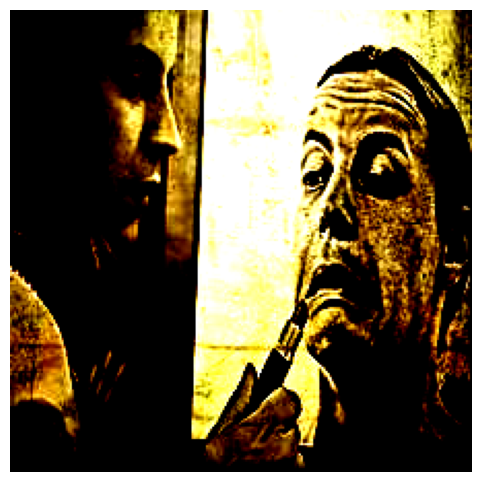

In [10]:
plt.imshow(train_loader.dataset[1000][0].permute(1, 2, 0))
plt.axis('off')
plt.show()

## Image Classification using MLFFNN

In [11]:
class ImageClassification:
    def __init__(self, model, criterion, optimizer, save=True):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.train_accuracies = []
        self.valid_losses = []
        self.valid_accuracies = []
        self.save = save

        if os.path.exists('models/Q2_checkpoint.pt') and self.save:
            checkpoint = torch.load('models/Q2_checkpoint.pt', map_location=device)
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.train_losses = checkpoint['losses']['train']
            self.train_accuracies = checkpoint['accuracies']['train']
            self.valid_losses = checkpoint['losses']['valid']
            self.valid_accuracies = checkpoint['accuracies']['valid']

        self.start_epoch = len(self.train_losses)

    def train(self, train_loader, valid_loader, num_epochs=5):
        for epoch in range(self.start_epoch, num_epochs):
            tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm_train_loader):
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tqdm_train_loader.set_postfix({'Running Loss': running_loss / (i + 1)})
                tqdm_train_loader.set_description(f"Epoch {epoch+1}/{num_epochs}")

            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            valid_loss, val_accuracy = self.evaluate(valid_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_losses.append(valid_loss)
            self.valid_accuracies.append(val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
            print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}')
            # save checkpoint to cpu
            if self.save:
                torch.save({
                    'model': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    'losses': {'train': self.train_losses, 'valid': self.valid_losses},
                    'accuracies': {'train': self.train_accuracies, 'valid': self.valid_accuracies}
                }, 'models/Q2_checkpoint.pt')

    def evaluate(self, valid_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        valid_loss = running_loss / len(valid_loader)
        return valid_loss, val_accuracy

    def test(self, test_loader):
        test_loss, test_accuracy = self.evaluate(test_loader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    def plot_cm_train(self, train_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 10))
        annot_labels = np.array([[f'{norm*100:.2f}%' for norm in row] for row in cm_norm])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes, cmap='YlGnBu')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.title('Confusion Matrix (Train)')
        plt.axis('equal')
        plt.savefig(f'plots/Q2/confusion_matrix_train.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_cm_test(self, test_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 10))
        annot_labels = np.array([[f'{norm*100:.2f}%' for norm in row] for row in cm_norm])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes, cmap='YlGnBu')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.title('Confusion Matrix (Test)')
        plt.savefig(f'plots/confusion_matrix_test.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        # plt.legend()
        # plt.title('Train Loss')
        plt.savefig(f'plots/train_losses.pdf', format='pdf', bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.valid_losses, label='Valid Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        # plt.legend()
        # plt.title('Valid Loss')
        plt.savefig(f'plots/valid_losses.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        # plt.legend()
        # plt.title('Train Accuracy')
        plt.savefig(f'plots/train_accuracies.pdf', format='pdf', bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.valid_accuracies, label='Valid Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        # plt.legend()
        # plt.title('Valid Accuracy')
        plt.savefig(f'plots/valid_accuracies.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))



In [12]:
class CNN(nn.Module):
    def __init__(self, cl2_feature_maps, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=cl2_feature_maps, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=cl2_feature_maps * 56 * 56, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
# print the CNN architecture
model = CNN(cl2_feature_maps=8, num_classes=len(train_dataset.classes)).to(device)
model

CNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=5, bias=True)
)

Epoch 1/10: 100%|██████████| 63/63 [00:09<00:00,  6.67batch/s, Running Loss=1.28]


Epoch 1/10, Train Loss: 1.2818, Train Accuracy: 0.4740
Epoch 1/10, Valid Loss: 1.1168, Valid Accuracy: 0.5940


Epoch 2/10: 100%|██████████| 63/63 [00:05<00:00, 11.70batch/s, Running Loss=0.904]


Epoch 2/10, Train Loss: 0.9042, Train Accuracy: 0.6595
Epoch 2/10, Valid Loss: 0.9640, Valid Accuracy: 0.6500


Epoch 3/10: 100%|██████████| 63/63 [00:06<00:00, 10.22batch/s, Running Loss=0.603]


Epoch 3/10, Train Loss: 0.6029, Train Accuracy: 0.7905
Epoch 3/10, Valid Loss: 1.0433, Valid Accuracy: 0.6400


Epoch 4/10: 100%|██████████| 63/63 [00:05<00:00, 12.02batch/s, Running Loss=0.275]


Epoch 4/10, Train Loss: 0.2751, Train Accuracy: 0.9150
Epoch 4/10, Valid Loss: 1.1649, Valid Accuracy: 0.6680


Epoch 5/10: 100%|██████████| 63/63 [00:06<00:00, 10.44batch/s, Running Loss=0.101]


Epoch 5/10, Train Loss: 0.1010, Train Accuracy: 0.9745
Epoch 5/10, Valid Loss: 1.3291, Valid Accuracy: 0.6680


Epoch 6/10: 100%|██████████| 63/63 [00:05<00:00, 11.72batch/s, Running Loss=0.0498]


Epoch 6/10, Train Loss: 0.0498, Train Accuracy: 0.9900
Epoch 6/10, Valid Loss: 1.6755, Valid Accuracy: 0.6360


Epoch 7/10: 100%|██████████| 63/63 [00:05<00:00, 10.90batch/s, Running Loss=0.0213]


Epoch 7/10, Train Loss: 0.0213, Train Accuracy: 0.9970
Epoch 7/10, Valid Loss: 1.6929, Valid Accuracy: 0.6560


Epoch 8/10: 100%|██████████| 63/63 [00:05<00:00, 11.64batch/s, Running Loss=0.0232]


Epoch 8/10, Train Loss: 0.0232, Train Accuracy: 0.9960
Epoch 8/10, Valid Loss: 1.7216, Valid Accuracy: 0.6240


Epoch 9/10: 100%|██████████| 63/63 [00:05<00:00, 11.33batch/s, Running Loss=0.0197]


Epoch 9/10, Train Loss: 0.0197, Train Accuracy: 0.9955
Epoch 9/10, Valid Loss: 1.8269, Valid Accuracy: 0.6400


Epoch 10/10: 100%|██████████| 63/63 [00:05<00:00, 11.20batch/s, Running Loss=0.00227]


Epoch 10/10, Train Loss: 0.0023, Train Accuracy: 1.0000
Epoch 10/10, Valid Loss: 1.8410, Valid Accuracy: 0.6640



Epoch 1/10: 100%|██████████| 63/63 [00:07<00:00,  8.96batch/s, Running Loss=1.14]


Epoch 1/10, Train Loss: 1.1376, Train Accuracy: 0.5745
Epoch 1/10, Valid Loss: 1.0151, Valid Accuracy: 0.6160


Epoch 2/10: 100%|██████████| 63/63 [00:05<00:00, 11.61batch/s, Running Loss=0.75]


Epoch 2/10, Train Loss: 0.7503, Train Accuracy: 0.7295
Epoch 2/10, Valid Loss: 1.0036, Valid Accuracy: 0.6120


Epoch 3/10: 100%|██████████| 63/63 [00:05<00:00, 11.90batch/s, Running Loss=0.485]


Epoch 3/10, Train Loss: 0.4846, Train Accuracy: 0.8225
Epoch 3/10, Valid Loss: 0.9964, Valid Accuracy: 0.6700


Epoch 4/10: 100%|██████████| 63/63 [00:05<00:00, 10.76batch/s, Running Loss=0.226]


Epoch 4/10, Train Loss: 0.2257, Train Accuracy: 0.9290
Epoch 4/10, Valid Loss: 1.1976, Valid Accuracy: 0.6620


Epoch 5/10: 100%|██████████| 63/63 [00:05<00:00, 11.97batch/s, Running Loss=0.115]


Epoch 5/10, Train Loss: 0.1155, Train Accuracy: 0.9670
Epoch 5/10, Valid Loss: 1.3840, Valid Accuracy: 0.6600


Epoch 6/10: 100%|██████████| 63/63 [00:06<00:00, 10.46batch/s, Running Loss=0.0467]


Epoch 6/10, Train Loss: 0.0467, Train Accuracy: 0.9895
Epoch 6/10, Valid Loss: 1.3851, Valid Accuracy: 0.6680


Epoch 7/10: 100%|██████████| 63/63 [00:05<00:00, 11.96batch/s, Running Loss=0.0246]


Epoch 7/10, Train Loss: 0.0246, Train Accuracy: 0.9950
Epoch 7/10, Valid Loss: 1.4280, Valid Accuracy: 0.6680


Epoch 8/10: 100%|██████████| 63/63 [00:05<00:00, 10.53batch/s, Running Loss=0.00456]


Epoch 8/10, Train Loss: 0.0046, Train Accuracy: 1.0000
Epoch 8/10, Valid Loss: 1.5667, Valid Accuracy: 0.6700


Epoch 9/10: 100%|██████████| 63/63 [00:05<00:00, 12.06batch/s, Running Loss=0.00173]


Epoch 9/10, Train Loss: 0.0017, Train Accuracy: 1.0000
Epoch 9/10, Valid Loss: 1.5929, Valid Accuracy: 0.6780


Epoch 10/10: 100%|██████████| 63/63 [00:06<00:00, 10.36batch/s, Running Loss=0.00102]


Epoch 10/10, Train Loss: 0.0010, Train Accuracy: 1.0000
Epoch 10/10, Valid Loss: 1.6387, Valid Accuracy: 0.6860



Epoch 1/10: 100%|██████████| 63/63 [00:05<00:00, 10.90batch/s, Running Loss=1.97]


Epoch 1/10, Train Loss: 1.9713, Train Accuracy: 0.4520
Epoch 1/10, Valid Loss: 1.0526, Valid Accuracy: 0.6300


Epoch 2/10: 100%|██████████| 63/63 [00:08<00:00,  7.85batch/s, Running Loss=0.86]


Epoch 2/10, Train Loss: 0.8600, Train Accuracy: 0.6895
Epoch 2/10, Valid Loss: 0.8986, Valid Accuracy: 0.6760


Epoch 3/10: 100%|██████████| 63/63 [00:05<00:00, 11.41batch/s, Running Loss=0.636]


Epoch 3/10, Train Loss: 0.6357, Train Accuracy: 0.7745
Epoch 3/10, Valid Loss: 0.8635, Valid Accuracy: 0.6820


Epoch 4/10: 100%|██████████| 63/63 [00:06<00:00, 10.11batch/s, Running Loss=0.412]


Epoch 4/10, Train Loss: 0.4118, Train Accuracy: 0.8750
Epoch 4/10, Valid Loss: 0.9782, Valid Accuracy: 0.6620


Epoch 5/10: 100%|██████████| 63/63 [00:05<00:00, 11.46batch/s, Running Loss=0.272]


Epoch 5/10, Train Loss: 0.2720, Train Accuracy: 0.9175
Epoch 5/10, Valid Loss: 0.9141, Valid Accuracy: 0.7020


Epoch 6/10: 100%|██████████| 63/63 [00:06<00:00, 10.23batch/s, Running Loss=0.123]


Epoch 6/10, Train Loss: 0.1226, Train Accuracy: 0.9750
Epoch 6/10, Valid Loss: 1.0907, Valid Accuracy: 0.6860


Epoch 7/10: 100%|██████████| 63/63 [00:05<00:00, 11.32batch/s, Running Loss=0.0594]


Epoch 7/10, Train Loss: 0.0594, Train Accuracy: 0.9905
Epoch 7/10, Valid Loss: 1.1793, Valid Accuracy: 0.6800


Epoch 8/10: 100%|██████████| 63/63 [00:06<00:00, 10.43batch/s, Running Loss=0.0499]


Epoch 8/10, Train Loss: 0.0499, Train Accuracy: 0.9890
Epoch 8/10, Valid Loss: 1.2209, Valid Accuracy: 0.6620


Epoch 9/10: 100%|██████████| 63/63 [00:05<00:00, 11.16batch/s, Running Loss=0.0209]


Epoch 9/10, Train Loss: 0.0209, Train Accuracy: 0.9980
Epoch 9/10, Valid Loss: 1.2685, Valid Accuracy: 0.6980


Epoch 10/10: 100%|██████████| 63/63 [00:05<00:00, 10.85batch/s, Running Loss=0.0131]


Epoch 10/10, Train Loss: 0.0131, Train Accuracy: 0.9990
Epoch 10/10, Valid Loss: 1.3812, Valid Accuracy: 0.7000



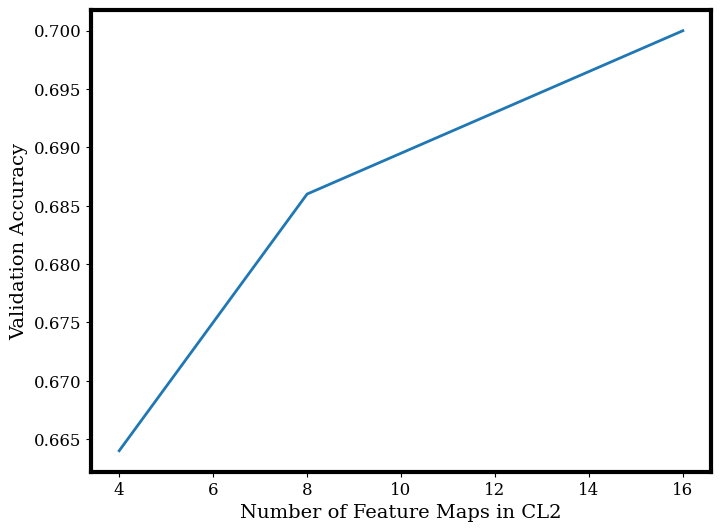

In [14]:
# Hyperparameter tuning for the number of feature maps in CL2
# Use the validation dataset to tune the hyperparameter
# Plot the validation accuracy vs the number of feature maps in CL2
# Choose the hyperparameter that gives the best validation accuracy

cl2_feature_maps = [4, 8, 16]
valid_accuracies = []
for cl2 in cl2_feature_maps:
    model = CNN(cl2, len(train_dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    image_classification = ImageClassification(model, criterion, optimizer, save=False)
    image_classification.train(train_loader, valid_loader, num_epochs=10)
    valid_accuracies.append(image_classification.valid_accuracies[-1])
    print("")

plt.figure(figsize=(8, 6))
plt.plot(cl2_feature_maps, valid_accuracies)
plt.xlabel('Number of Feature Maps in CL2')
plt.ylabel('Validation Accuracy')
# plt.title('Validation Accuracy vs Number of Feature Maps in CL2')
plt.savefig('plots/Q2/hyperparameter_tuning.pdf', format='pdf', bbox_inches='tight')
plt.show()


Epoch 1/10: 100%|██████████| 63/63 [00:05<00:00, 10.81batch/s, Running Loss=1.99]


Epoch 1/10, Train Loss: 1.9928, Train Accuracy: 0.4335
Epoch 1/10, Valid Loss: 1.2673, Valid Accuracy: 0.4780


Epoch 2/10: 100%|██████████| 63/63 [00:06<00:00,  9.85batch/s, Running Loss=0.992]


Epoch 2/10, Train Loss: 0.9924, Train Accuracy: 0.6245
Epoch 2/10, Valid Loss: 0.9638, Valid Accuracy: 0.6520


Epoch 3/10: 100%|██████████| 63/63 [00:05<00:00, 11.08batch/s, Running Loss=0.753]


Epoch 3/10, Train Loss: 0.7531, Train Accuracy: 0.7390
Epoch 3/10, Valid Loss: 0.8605, Valid Accuracy: 0.7120


Epoch 4/10: 100%|██████████| 63/63 [00:06<00:00, 10.40batch/s, Running Loss=0.572]


Epoch 4/10, Train Loss: 0.5719, Train Accuracy: 0.8015
Epoch 4/10, Valid Loss: 0.8737, Valid Accuracy: 0.6700


Epoch 5/10: 100%|██████████| 63/63 [00:05<00:00, 10.58batch/s, Running Loss=0.388]


Epoch 5/10, Train Loss: 0.3875, Train Accuracy: 0.8685
Epoch 5/10, Valid Loss: 1.0701, Valid Accuracy: 0.6440


Epoch 6/10: 100%|██████████| 63/63 [00:05<00:00, 10.98batch/s, Running Loss=0.27]


Epoch 6/10, Train Loss: 0.2703, Train Accuracy: 0.9195
Epoch 6/10, Valid Loss: 0.9789, Valid Accuracy: 0.6940


Epoch 7/10: 100%|██████████| 63/63 [00:06<00:00,  9.88batch/s, Running Loss=0.146]


Epoch 7/10, Train Loss: 0.1457, Train Accuracy: 0.9625
Epoch 7/10, Valid Loss: 1.0445, Valid Accuracy: 0.6780


Epoch 8/10: 100%|██████████| 63/63 [00:05<00:00, 11.29batch/s, Running Loss=0.0949]


Epoch 8/10, Train Loss: 0.0949, Train Accuracy: 0.9760
Epoch 8/10, Valid Loss: 1.1461, Valid Accuracy: 0.6880


Epoch 9/10: 100%|██████████| 63/63 [00:06<00:00,  9.71batch/s, Running Loss=0.0585]


Epoch 9/10, Train Loss: 0.0585, Train Accuracy: 0.9885
Epoch 9/10, Valid Loss: 1.3138, Valid Accuracy: 0.6840


Epoch 10/10: 100%|██████████| 63/63 [00:05<00:00, 11.08batch/s, Running Loss=0.0224]


Epoch 10/10, Train Loss: 0.0224, Train Accuracy: 0.9980
Epoch 10/10, Valid Loss: 1.3480, Valid Accuracy: 0.6840
Test Loss: 1.4636, Test Accuracy: 0.6560


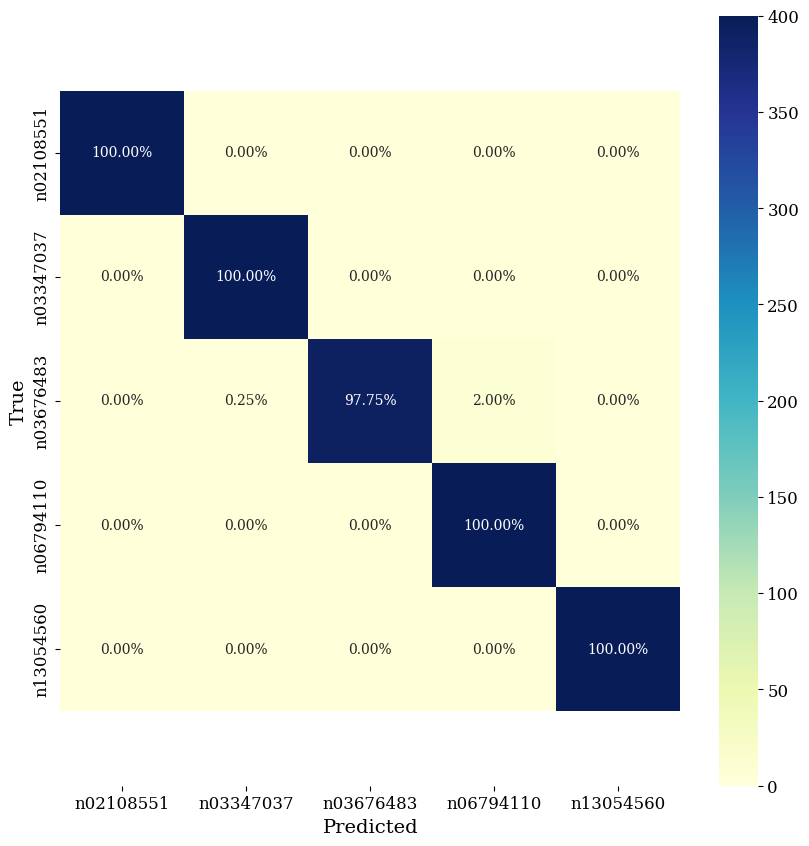

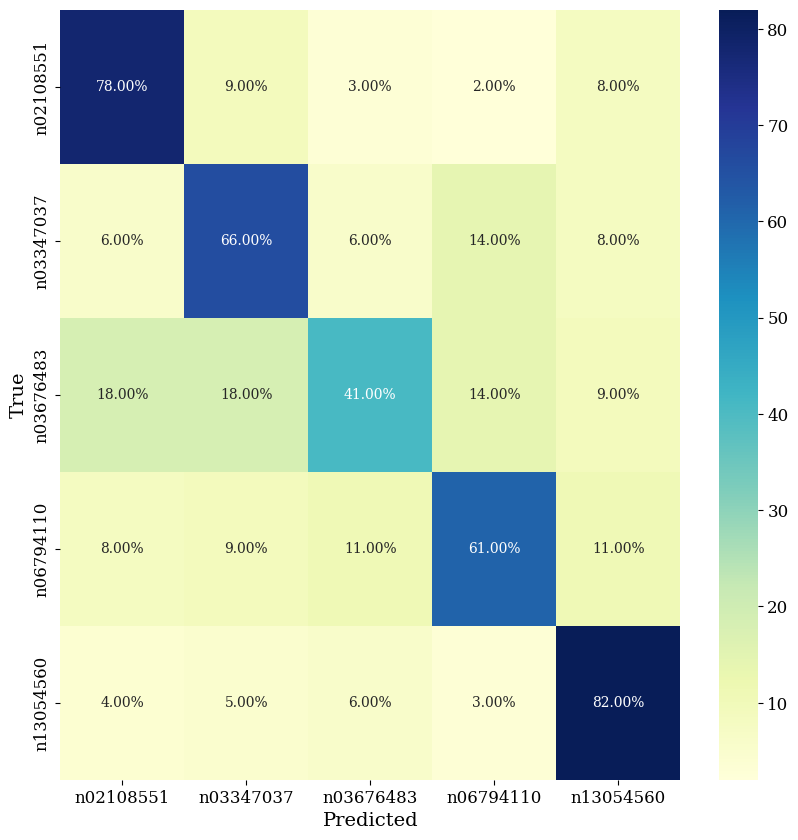

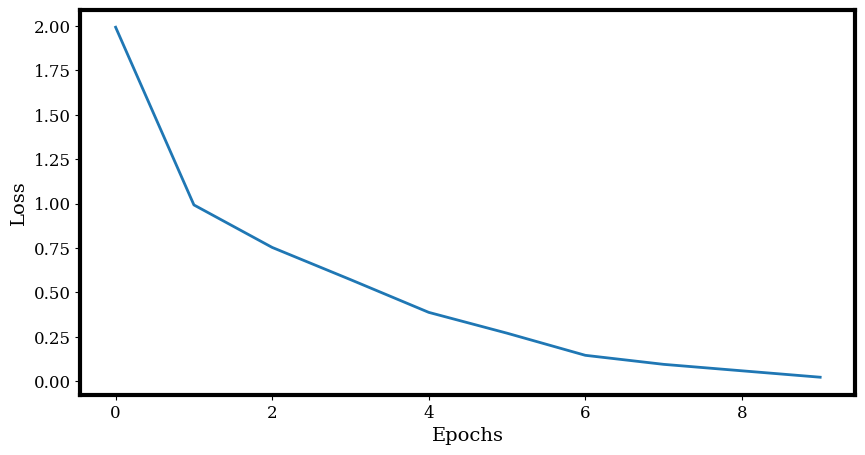

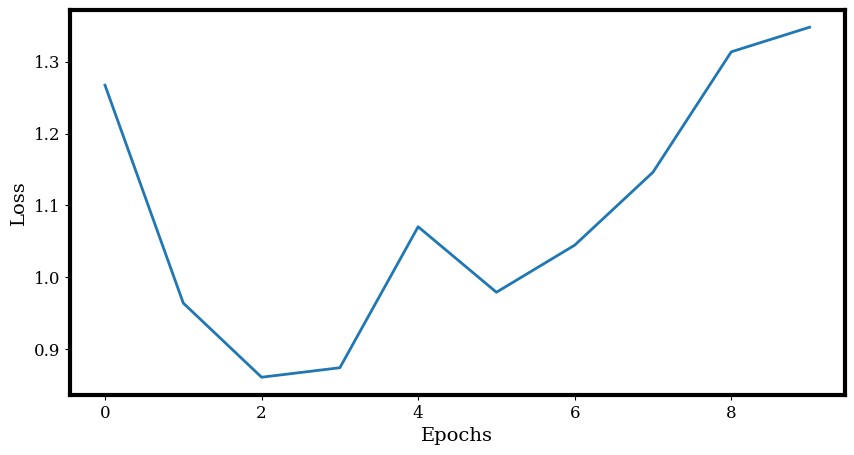

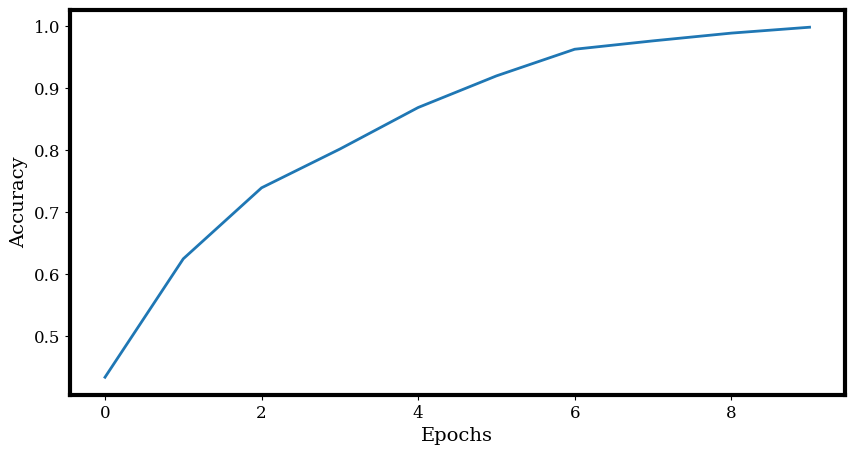

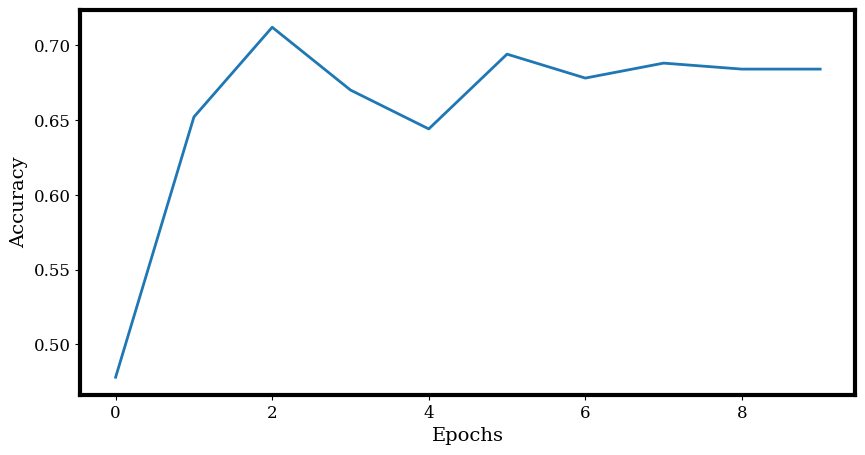

In [34]:
# 8 didnt train well, 32 overfitted
cl2_feature_maps = 8
num_classes = len(train_dataset.classes) # = 5

# Initialize the model, loss function, and optimizer
model = CNN(cl2_feature_maps, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

image_classification = ImageClassification(model, criterion, optimizer)
image_classification.train(train_loader, valid_loader, num_epochs=10)
image_classification.test(test_loader)

# Plot confusion matrix, losses, and accuracies
image_classification.plot_cm_train(train_loader)
image_classification.plot_cm_test(test_loader)
image_classification.plot_losses()
image_classification.plot_accuracies()


In [ ]:
# import zipfile
# import os

# # Define the path to the folder you want to zip
# folder_path = '/content/plots/Q2'

# # Define the path for the zip file
# zip_path = '/content/plots/Q2.zip'

# # Create a zip file of the folder
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

# # Download the zip file
# from google.colab import files
# files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>